<img src="https://www3.um.edu.uy/logoum.jpg" width=300>
<h1 align="center">Thesis - ALS F1 </h1> 
<h2 align="center">Alejo Paullier</h2> 

https://lkpy.lenskit.org/en/stable/knn.html

In [1]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als
from lenskit.algorithms.als import BiasedMF
import pandas as pd
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

ratings = pd.read_csv('C:\\Users\\Alejo\\Tesis\\Demo\\ml-100k\\u.data', sep='\t',
                      names=['user', 'item', 'rating', 'timestamp'])


def eval(aname, algo, train, test):
    fittable = util.clone(algo) # Object cloning means to create an exact copy of the original object.
    fittable = Recommender.adapt(fittable) 
    fittable.fit(train) # Entrenamos el algoritmo con el training dataset
    users = test.user.unique() # Devuelve un array con los users unicos en el testing dataset
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [14]:
def model_trainer(features,reg):
    all_recs = []
    test_data = []
    features=int(features)
    als = BiasedMF(features=features, iterations=100, reg=reg, damping=5, bias=True,  progress=None) # define algorithm
     
    for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
        test_data.append(test) # save testing data
        all_recs.append(eval('ALS', als, train, test))
    
    all_recs = pd.concat(all_recs, ignore_index=True)
    test_data = pd.concat(test_data, ignore_index=True)
    rla1 = topn.RecListAnalysis()
    rla2 = topn.RecListAnalysis()
    rla1.add_metric(topn.precision)
    rla2.add_metric(topn.recall)
    prec = rla1.compute(all_recs, test_data)
    rec = rla2.compute(all_recs, test_data)
    F1 = ((prec['precision'].values*rec['recall'].values*2)/(prec['precision'].values+rec['recall'].values))
    F1 = np.nan_to_num(F1)
    return [F1.mean(),prec['precision'].mean(),rec['recall'].mean()]

In [15]:
from hyperopt import fmin, tpe, hp, STATUS_OK

def objective(params):
    features = params['features']
    reg = params['reg']
    metric = model_trainer(features,reg)
    print([features,reg,metric[0],metric[1],metric[2]],',')
    return {'loss': -metric[0], 'status': STATUS_OK }

space={'features': hp.uniform('features', 1, 100),
       'reg': hp.uniform('reg',0.01,0.4)}

best = fmin(objective, space, algo=tpe.suggest,max_evals=100)

[1.449087859543894, 0.3480902933316383, 0.061060636677251624, 0.04127253446447512, 0.18451445930228444]                
,                                                                                                                      
[48.72617648924081, 0.33091375280964885, 0.0691928713037509, 0.047073170731707345, 0.20633890295250154]                
,                                                                                                                      
[76.73143452624369, 0.10185247703941598, 0.07052508203504732, 0.04783669141039243, 0.2129482022654655]                 
,                                                                                                                      
[21.645097426758596, 0.05645654392603892, 0.06548098851225836, 0.04458112407211037, 0.19440449014006492]               
,                                                                                                                      
[29.369131619372048, 0.2373485149435043,

[78.8571207613447, 0.3482079086804966, 0.06945893315049245, 0.04733828207847308, 0.20331737877649056]                  
,                                                                                                                      
[59.79614924285262, 0.24530498319316416, 0.06808944313194547, 0.04651113467656419, 0.20148042310938252]                
,                                                                                                                      
[91.9753305577753, 0.2923444289004852, 0.0693544814241482, 0.04717921527041359, 0.2052316835071901]                    
,                                                                                                                      
[66.08068300123753, 0.3854893437337882, 0.07014294462491771, 0.04759278897136807, 0.21119518851084101]                 
,                                                                                                                      
[84.24635591520841, 0.27058518539097953,

In [17]:
metric = pd.DataFrame(array)
metric.columns = ['neighbours','center','F1','Precision','Recall']
metric.head(5)

,neighbours,center,F1,Precision,Recall
0,1.449088,0.348090,0.061061,0.041273,0.184514
1,48.726176,0.330914,0.069193,0.047073,0.206339
2,76.731435,0.101852,0.070525,0.047837,0.212948
3,21.645097,0.056457,0.065481,0.044581,0.194404
4,29.369132,0.237349,0.065815,0.044804,0.193883


In [18]:
metric.sort_values(by=['F1'],ascending=False).head(10)

,neighbours,center,F1,Precision,Recall
5,83.756923,0.263044,0.072044,0.049046,0.214865
11,95.988572,0.286848,0.071656,0.048897,0.211226
93,52.512343,0.225201,0.071358,0.048484,0.213163
29,82.495986,0.319981,0.071275,0.048473,0.214118
85,66.107220,0.278408,0.071188,0.048367,0.213569
45,94.191320,0.182755,0.071168,0.048335,0.214791
51,85.951433,0.250065,0.071097,0.048208,0.217019
66,82.834247,0.310506,0.071068,0.048314,0.214216
16,64.403534,0.202503,0.070969,0.048112,0.215789
19,67.496986,0.190953,0.070876,0.048303,0.208366


In [5]:
metric.to_csv('metric_F1.csv', index=False)

In [7]:
metric = pd.read_csv('C:\\Users\\Alejo\\Tesis\\Algoritmos\\Alternating Least Squares\\results\\metric_F1.csv', sep=',')

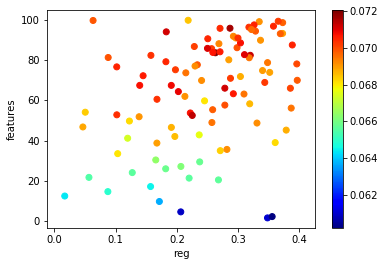

In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm
colormap = cm.hot
x = metric['reg']
y = metric['features'] 
c = metric['F1']


fig = plt.figure()
img = plt.scatter(x, y, c=c, cmap=plt.jet())
plt.xlabel('reg')
plt.ylabel('features')
fig.colorbar(img)
plt.show()